In [340]:
import glob
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import norm
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

# Load Data

In [132]:
files = glob.glob('data/Unidirectional/Combined/*.csv')
files.extend(glob.glob('data/Bidirectional/Combined/*.csv'))

print(f"Loaded {len(files)} files")

Loaded 36 files


In [138]:
combined = pd.DataFrame(columns=["Participant","Condition","Response","Test Stim","Test Speed","Correct","Time"])
subjects = set()

for file in files:
    name = file[file.rfind('/')+1:][:3]
    subjects.add(name)

    t_type = 'Unidirectional' if 'Unidirectional' in file else 'Bidirectional'
    if 'noAdapt' in file:
        t_type = 'No Adapt'
    else:
        t_type += ' Adapt'

    participant_data = pd.read_csv(file, index_col=0)
    participant_data["Participant"] = name
    participant_data["Condition"] = t_type
    combined = pd.concat([combined, participant_data], axis=0)

subject_list = sorted(list(subjects))
combined.to_csv("./data/combined.csv")
combined.head()

/var/folders/38/cyy5p2n96d1fr3wzqvg05w4c0000gn/T/ipykernel_65538/1851597303.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([combined, participant_data], axis=0)


,Participant,Condition,Response,Test Stim,Test Speed,Correct,Time
0,nxn,Unidirectional Adapt,right,log,38.0,True,0.941106
1,nxn,Unidirectional Adapt,right,mirror,62.0,True,1.054182
2,nxn,Unidirectional Adapt,right,mirror,62.0,True,1.238950
3,nxn,Unidirectional Adapt,left,log,70.0,False,2.613170
4,nxn,Unidirectional Adapt,right,mirror,70.0,True,0.793902


In [319]:
dsubjects = {
    "ccw": ["jdg", "nst", "nxs", "mxw", "tee", "ksm"],
    "cw": ["anb", "kxt", "mjl", "nxn", "sxk", "txd"],
}

# Psychometric Function Fitting

In [347]:
output = pd.DataFrame(columns=['Name', 'Exp Type', 'Mu', 'Sigma', 'Floor', 'Ceiling', 'R^2', 'Direction'])

/var/folders/38/cyy5p2n96d1fr3wzqvg05w4c0000gn/T/ipykernel_65538/1697642990.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc='lower right', framealpha=0.5)


[0.88619542 0.92530534 0.95202066 0.96838646 0.97737761 0.9818075
 0.98376483 0.98454041 0.98481601 0.98490383 0.98492893] [0.975, 0.9, 0.925, 0.925, 0.925, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0] 0.015214903311731155 0.015340909090909075 0.008213710050116285


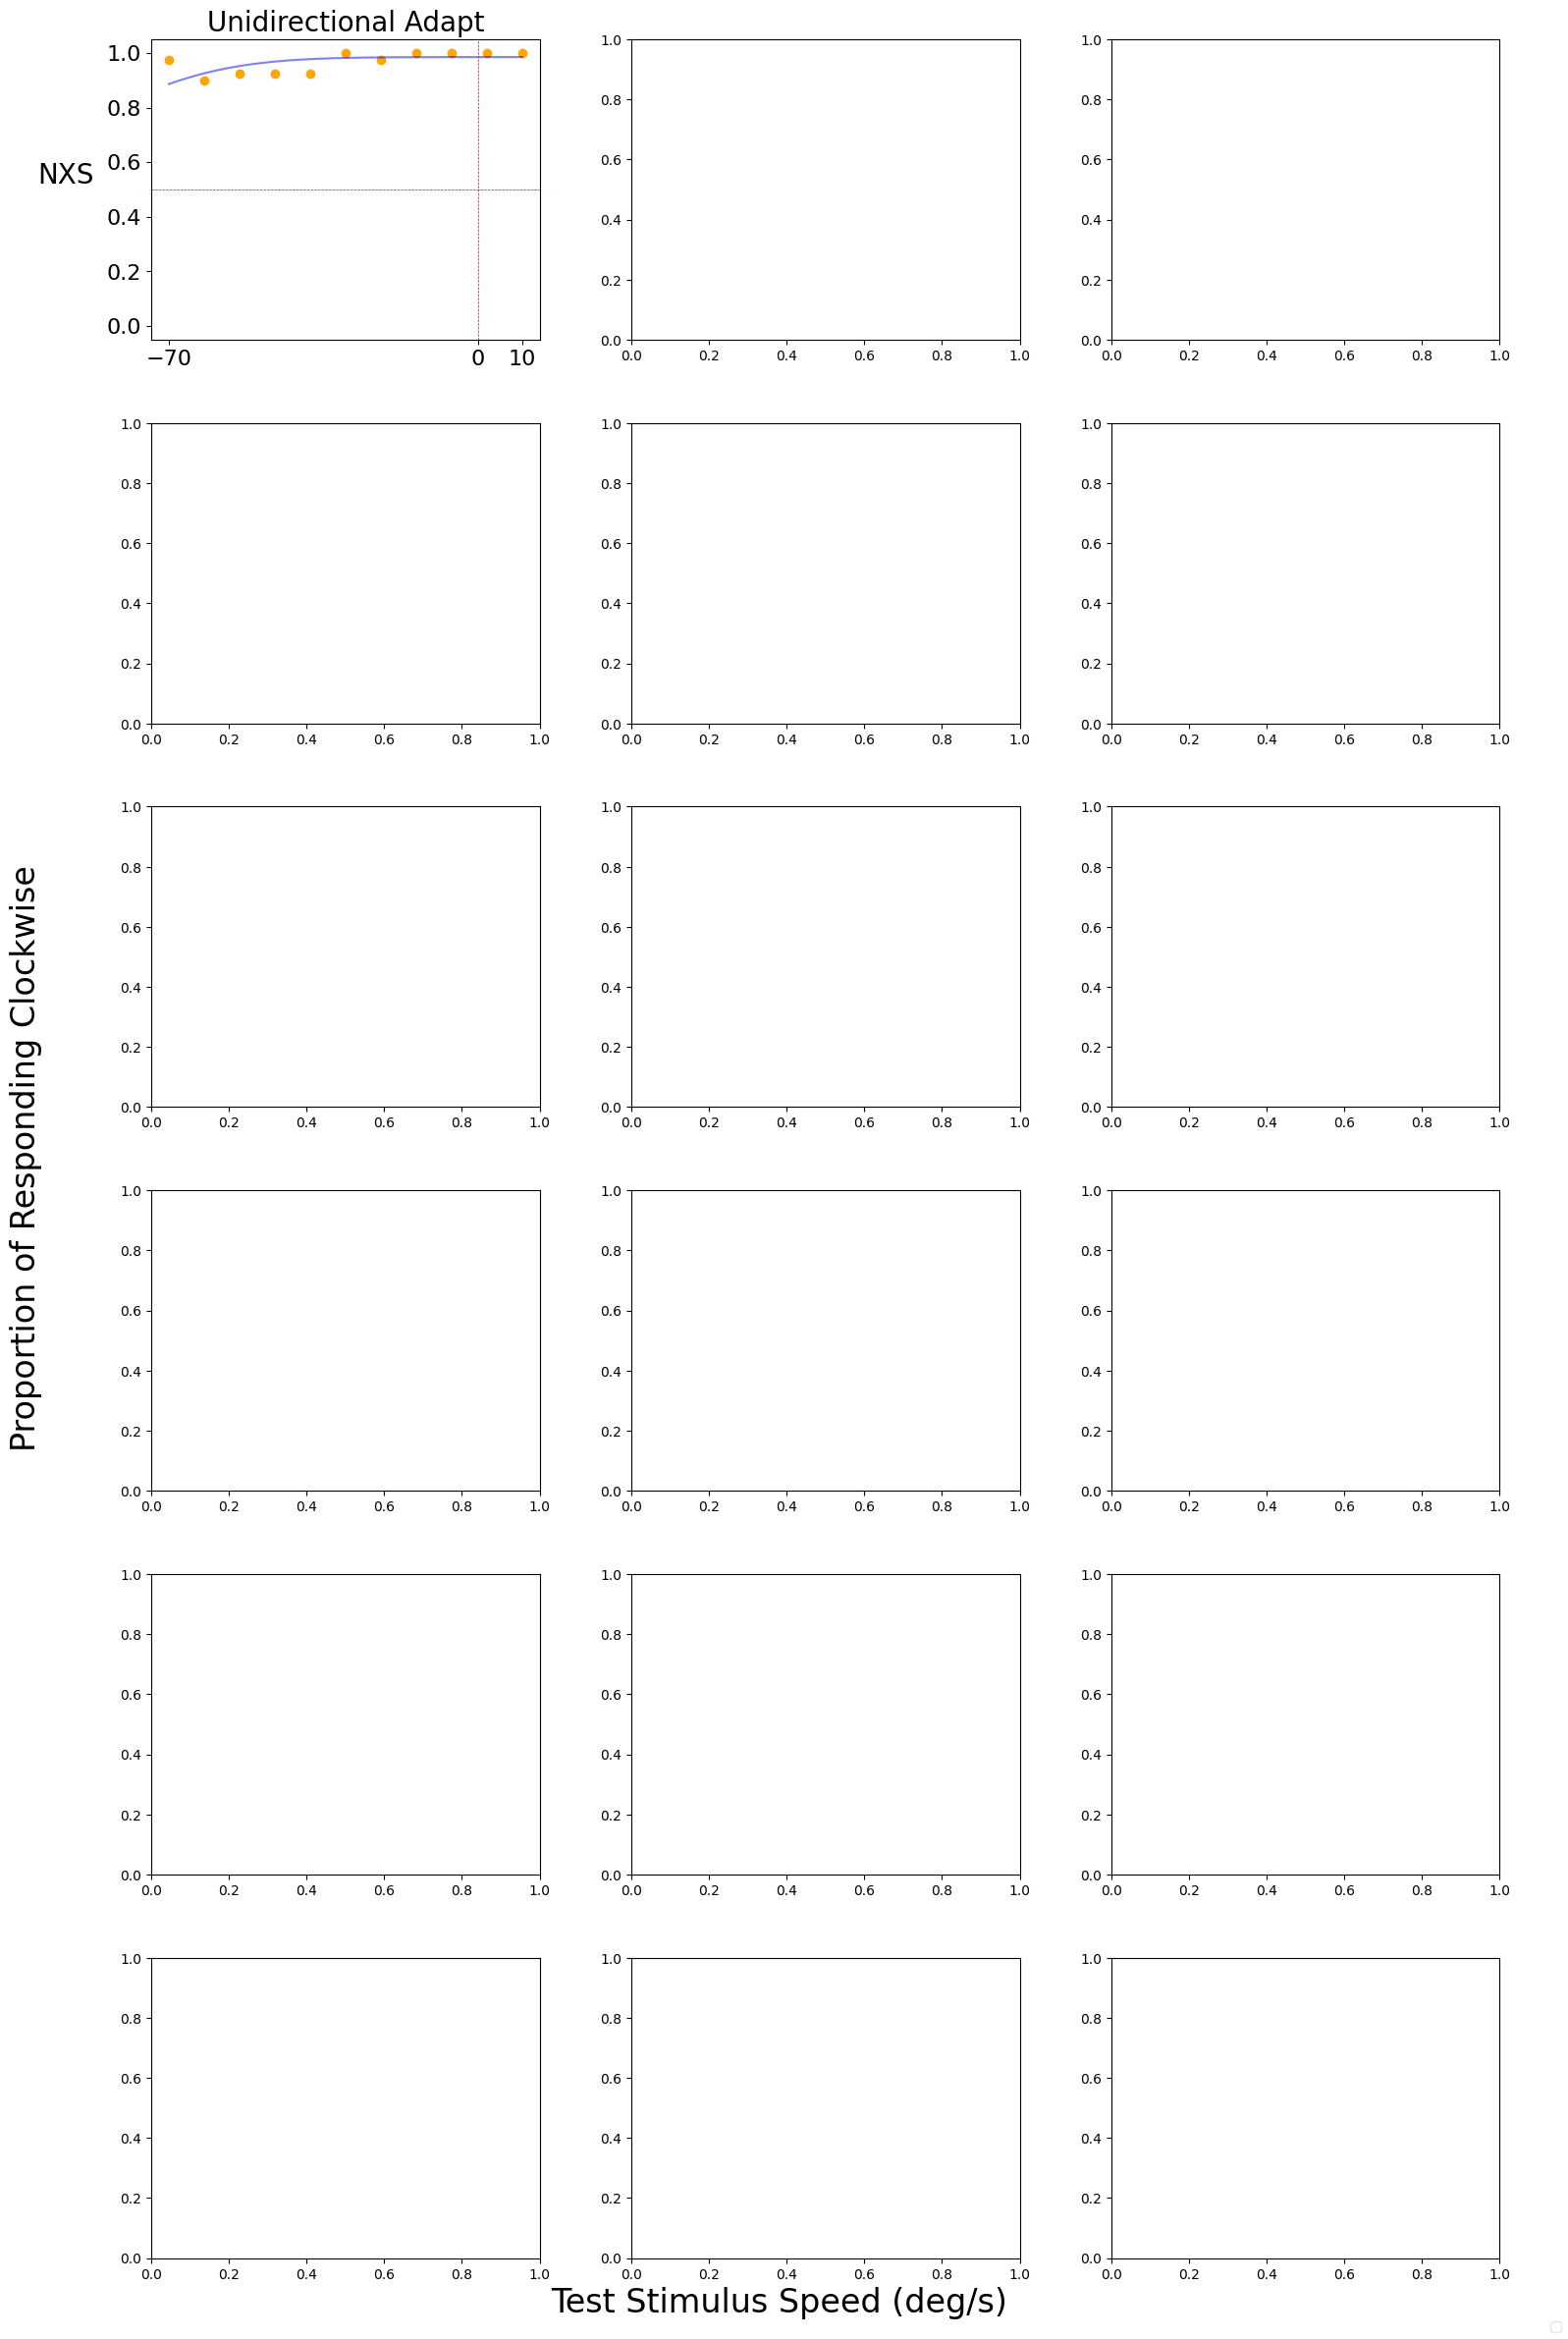

In [ ]:
PLOT_TYPE = "ccw"

def f(x, m, s, a, b):
    return a + (b - a) * norm.cdf(x, m, s)

NROWS = 6
NCOLS = 3
fig, ax = plt.subplots(NROWS, NCOLS, figsize=(16,24))
fig.legend(loc='lower right', framealpha=0.5)
fig.text(0.5, 0.01, 'Test Stimulus Speed (deg/s)', ha='center', fontsize=24)
fig.text(0.01, 0.5, 'Proportion of Responding Clockwise', va='center', rotation='vertical', fontsize=24)
fig.tight_layout(pad=4.0)

# for r, subject in enumerate(sorted(dsubjects[PLOT_TYPE])):
for r, subject in enumerate(["nxs"]):
    for c, condition in enumerate(["No Adapt", "Bidirectional Adapt", "Unidirectional Adapt"]):
        data = combined[(combined["Participant"] == subject) & (combined["Condition"] == condition)]

        count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
        total_counts = data.groupby('Test Speed').count()['Response']
        speeds = count_data.index.tolist()

        cw_counts = count_data.tolist()
        cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
        (mu, sigma, a, b), _ = curve_fit(
            f,
            speeds,
            cw_proportions,
            method='dogbox',
            p0=[0, 3, 0, 1],
            bounds=([-90, 0, 0, 0.5], [90, 90, 0.5, 1]),
        )

        pred = f(speeds, mu, sigma, a, b)
        r2 = r2_score(cw_proportions, pred)

        ax[r, c].scatter(speeds, cw_proportions, color='orange', label='Subject Data')

        t = np.linspace(min(speeds), max(speeds), 1000)
        ax[r, c].plot(t, f(t, mu, sigma, a, b), alpha=.5, color='blue', label='Guassian Fit')

        ax[r, c].axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed')
        ax[r, c].axvline(x=0, color='r', linewidth=0.5, linestyle='dashed')
        ax[r, c].set_ylim(-0.05, 1.05)

        ax[r, c].tick_params(axis='both', which='both', labelsize=16)
        if r == 0:
            ax[r, c].set_title(f'{condition}', fontsize=20)
        if c == 0:
            ax[r, c].set_ylabel(f'{subject.upper()}', labelpad=30, rotation=0, fontsize=20)
        if r != 0 or c != 0:
            ax[r, c].set_yticklabels([])
            ax[r, c].set_yticks([])

        if r > 0:
            ax[r, c].set_xticklabels([])
            ax[r, c].set_xticks([])
        else:
            match condition:
                case "No Adapt" | "Bidirectional Adapt":
                    ax[r, c].set_xticks([-40, 0, 40])
                case "Unidirectional Adapt":
                    ticks = [-70, 0, 10] if PLOT_TYPE == "ccw" else [-10, 0, 70]
                    ax[r, c].set_xticks(ticks)

        match condition:
            case "No Adapt":
                direction = ''
            case "Bidirectional Adapt":
                direction = 0
            case "Unidirectional Adapt":
                direction = -1 if min(speeds) < -40 else 1

        output.loc[len(output)] = [subject, condition, mu, sigma, a, b, r2, direction]
        handles, labels = ax[r, c].get_legend_handles_labels()

plt.subplots_adjust(left=0.1)
# plt.savefig(f"psychometric_fits_{PLOT_TYPE}.svg", pad_inches=0.1)
plt.show()

In [346]:
output.to_csv("gauss_fits.csv")

# Bootstrapping Confidence Intervals

Read https://acclab.github.io/bootstrap-confidence-intervals.html for more information.

In [332]:
np.random.seed(0)

cis = pd.DataFrame(columns=['Name', 'Exp Type', 'Mu CI', 'Sigma CI'])

100%|██████████| 12/12 [02:23<00:00, 11.98s/it]


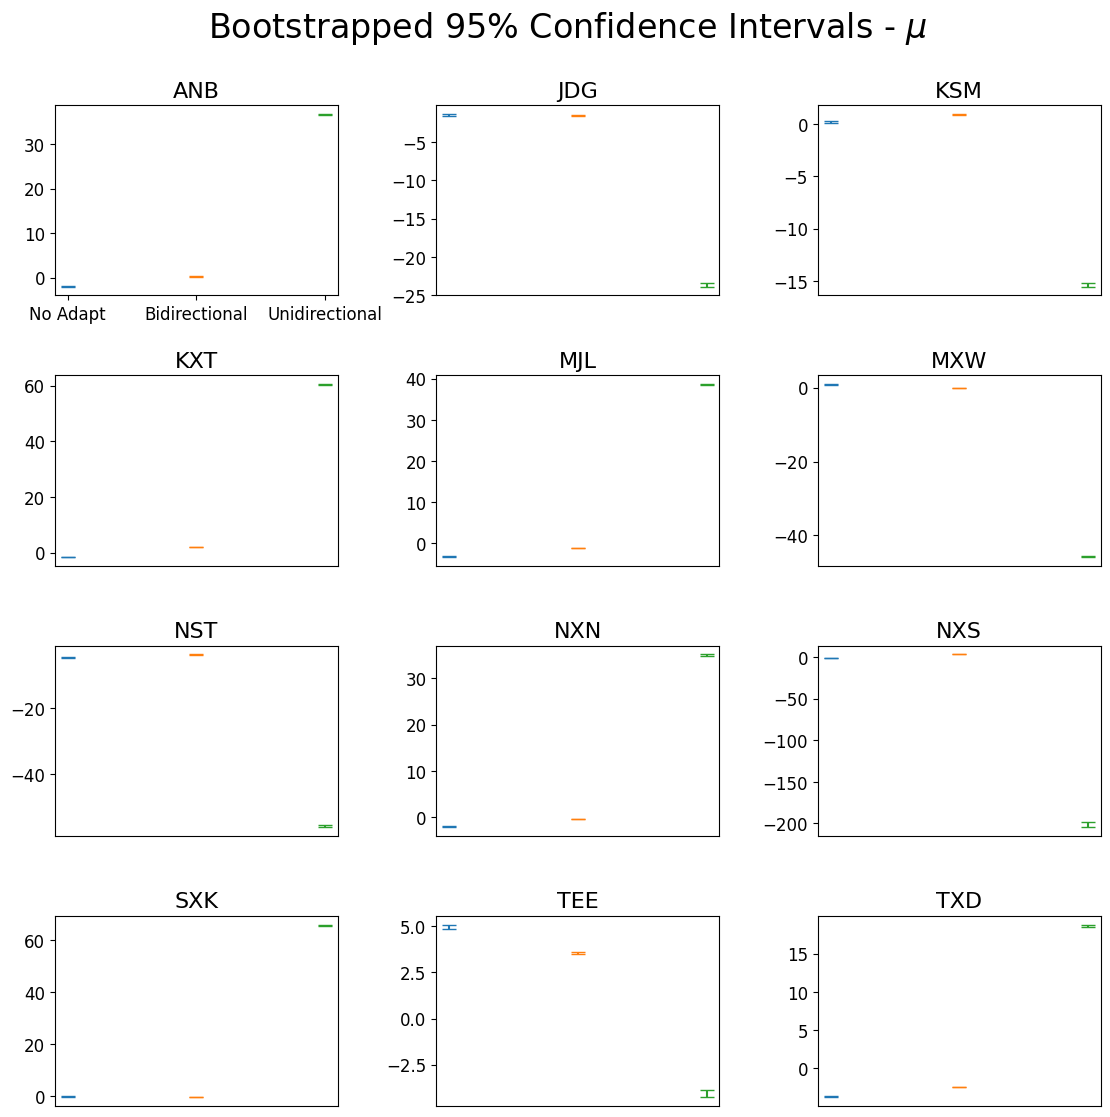

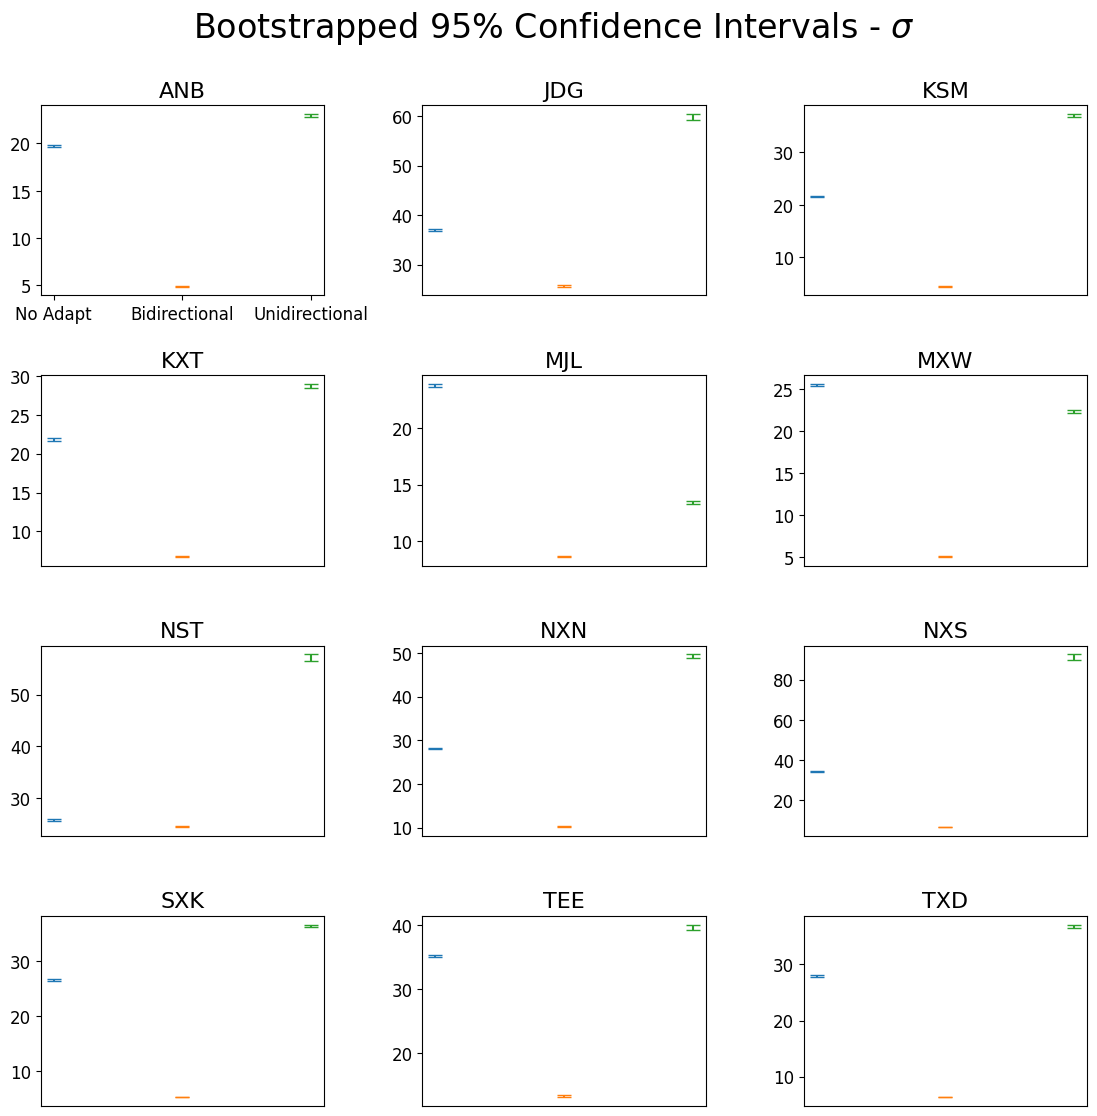

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [333]:
def confidence_interval(lst, alpha=0.95):
    return st.t.interval(
        alpha,
        df=len(lst)-1,
        loc=np.mean(lst),
        scale=st.sem(lst),
    )

def f(x, m, s):
    return norm.cdf(x, m, s)

N_SAMPLES = 1000

N_ROWS = 4
N_COLS = 3
fig_mu, ax_mu = plt.subplots(4, 3, figsize=(12, 12))
fig_mu.tight_layout(pad=4.0)
fig_mu.subplots_adjust(top=0.9)
fig_mu.suptitle("Bootstrapped 95% Confidence Intervals - $\mu$", fontsize=24)

fig_sigma, ax_sigma = plt.subplots(4, 3, figsize=(12, 12))
fig_sigma.tight_layout(pad=4.0)
fig_sigma.subplots_adjust(top=0.9)
fig_sigma.suptitle("Bootstrapped 95% Confidence Intervals - $\sigma$", fontsize=24)

for i, subject in enumerate(tqdm(subject_list)):
    plt.figure(figsize=(8, 6))
    for condition in ["No Adapt", "Bidirectional Adapt", "Unidirectional Adapt"]:
        original_data = combined[(combined["Participant"] == subject) & (combined["Condition"] == condition)]
        mus, sigmas = [], []
        for _ in range(N_SAMPLES):
            data = original_data.sample(replace=True, n=len(original_data))

            count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
            total_counts = data.groupby('Test Speed').count()['Response']
            speeds = count_data.index.tolist()

            cw_counts = count_data.tolist()
            cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
            (mu, sigma), _ = curve_fit(f, speeds, cw_proportions, method='dogbox', p0=[0, 2], maxfev=1500)

            mus.append(mu)
            sigmas.append(sigma)

        mu_ci = confidence_interval(mus)
        mu_err = (mu_ci[1] - mu_ci[0]) / 2

        sigma_ci = confidence_interval(sigmas)
        sigma_err = (sigma_ci[1] - sigma_ci[0]) / 2

        row, col = i // N_COLS, i % N_COLS

        label = condition if condition == "No Adapt" else condition.replace(" Adapt", "")
        ax_mu[row, col].tick_params(axis='both', which='both', labelsize=12)
        ax_mu[row, col].errorbar(label, np.mean(mus), yerr=mu_err, capsize=5)
        ax_mu[row, col].set_title(subject.upper(), fontsize=16)

        ax_sigma[row, col].tick_params(axis='both', which='both', labelsize=12)
        ax_sigma[row, col].errorbar(label, np.mean(sigmas), yerr=sigma_err, capsize=5)
        ax_sigma[row, col].set_title(subject.upper(), fontsize=16)

        if i > 0:
            ax_mu[row, col].set_xticklabels([])
            ax_mu[row, col].set_xticks([])
            ax_sigma[row, col].set_xticklabels([])
            ax_sigma[row, col].set_xticks([])

        cis.loc[len(cis)] = [subject, condition, mu_ci, sigma_ci]


fig_mu.savefig("ci_mu.svg")
fig_sigma.savefig("ci_sigma.svg")

In [357]:
cis.head()

,Name,Exp Type,Mu CI,Sigma CI
0,anb,No Adapt,"(-2.054, -1.909)","(19.631, 19.828)"
1,anb,Bidirectional Adapt,"(0.183, 0.261)","(4.862, 4.934)"
2,anb,Unidirectional Adapt,"(36.521, 36.777)","(22.791, 23.119)"
3,jdg,No Adapt,"(-1.568, -1.359)","(36.772, 37.166)"
4,jdg,Bidirectional Adapt,"(-1.598, -1.437)","(25.517, 25.785)"


In [ ]:
cis['Mu CI'] = cis['Mu CI'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))
cis['Sigma CI'] = cis['Sigma CI'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))
cis.to_csv('ci_data.csv')

# Aggregated Results

No Adapt Stats
[0.14375    0.20416667 0.19791667 0.19791667 0.28958333 0.51458333
 0.72083333 0.77708333 0.80833333 0.83958333 0.86666667]
[0.02134781 0.02800726 0.02270912 0.01753199 0.02392743 0.02546134
 0.01917655 0.02005162 0.03082412 0.02583058 0.0211715 ]
Adapt Stats
[0.04791667 0.05       0.06041667 0.08645833 0.128125   0.478125
 0.86041667 0.94375    0.94375    0.95729167 0.95520833]
[0.01677286 0.016855   0.02532148 0.02801254 0.02076456 0.03264409
 0.0225522  0.01979416 0.01887584 0.01565023 0.01638914]


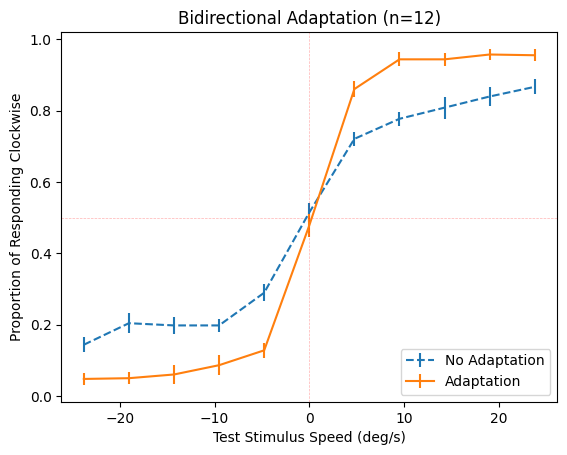

In [ ]:
files = glob.glob('data/Bidirectional/*.csv')
files = [f for f in files if '_practice' not in f]
files.sort()

files_noadapt = []
files_adapt = []
for subject in subjects:
    tmp = [f for f in files if subject in f]

    files_noadapt.append(tmp[0])
    files_adapt += tmp[1:-1]
    assert('_noAdapt' in tmp[0])
    assert('_Adapt' in tmp[1])
    assert('_Adapt' in tmp[2])

speeds_noadapt, props_noadapt = [], []
for f in files_noadapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds_noadapt = count_data.index.tolist()

    cw_counts = count_data.tolist()
    cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
    props_noadapt.append(cw_proportions)

speeds_adapt, props_adapt = [], []
for subject in subjects:
    dfs = [pd.read_csv(f, index_col=0) for f in files_adapt if subject in f[f.rfind('/'):]]
    data = pd.concat(dfs, axis=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']

    speeds_adapt = count_data.index.tolist()

    cw_counts = count_data.tolist()
    cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
    props_adapt.append(cw_proportions)

speeds_adapt = [s*0.595 for s in speeds_adapt]
speeds_noadapt = [s*0.595 for s in speeds_noadapt]
props_avg_noadapt = np.mean(props_noadapt, axis=0)
props_avg_adapt = np.mean(props_adapt, axis=0)

print("No Adapt Stats")
print("==============")
print(props_avg_noadapt)
print(sem(props_noadapt, axis=0))

print("Adapt Stats")
print("===========")
print(props_avg_adapt)
print(sem(props_adapt, axis=0))

plt.clf()
plt.errorbar(speeds_adapt, props_avg_noadapt, yerr=sem(props_noadapt, axis=0), linestyle='dashed', label='No Adaptation')
plt.errorbar(speeds_noadapt, props_avg_adapt, yerr=sem(props_adapt, axis=0), label='Adaptation')

plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title(f'Bidirectional Adaptation (n={len(subjects)})')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig('plots/average_bidirectional.svg')

No Adapt Stats
[0.1625     0.175      0.19791667 0.2125     0.30208333 0.55416667
 0.75833333 0.80625    0.81458333 0.87708333 0.87916667]
[0.02333469 0.0246183  0.01933025 0.02229706 0.02894259 0.02608141
 0.01880254 0.01689007 0.02619463 0.02392743 0.01533506]
Adapt Stats
[0.7291666666666666, 0.6708333333333334, 0.65, 0.5958333333333333, 0.45416666666666666, 0.3583333333333334, 0.25416666666666665, 0.17500000000000002, 0.7999999999999999, 0.12083333333333335, 0.8166666666666665, 0.075, 0.7333333333333334, 0.041666666666666664, 0.6750000000000002, 0.6166666666666667, 0.6, 0.5, 0.44166666666666665, 0.3708333333333334, 0.38749999999999996, 0.3125]
[0.01677286 0.016855   0.02532148 0.02801254 0.02076456 0.03264409
 0.0225522  0.01979416 0.01887584 0.01565023 0.01638914]


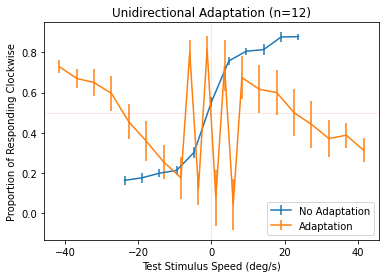

In [ ]:
files = glob.glob('data/Bidirectional/*.csv')
files = [f for f in files if '_practice' not in f]
files.sort()

files_noadapt = []
files_adapt = glob.glob('data/Unidirectional/*.csv')
for subject in subjects:
    tmp = [f for f in files if subject in f]
    files_noadapt.append(tmp[-1])
    assert('_noAdapt' in tmp[0])

speeds_noadapt, props_noadapt = [], []
for f in files_noadapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds_noadapt = count_data.index.tolist()

    cw_counts = count_data.tolist()
    cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
    props_noadapt.append(cw_proportions)

adapt_data = dict()
for f in files_adapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds = count_data.index.tolist()

    cw_counts = count_data.tolist()
    cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]

    for speed, prop in zip(speeds, cw_proportions):
        if -speed not in adapt_data.keys():
            adapt_data[-speed] = []
        adapt_data[-speed].append(prop)

speeds_noadapt = [s*0.595 for s in speeds_noadapt]
speeds_adapt = [s*0.595 for s in adapt_data.keys()]

props_avg_noadapt = np.mean(props_noadapt, axis=0)
props_avg_adapt = [np.mean(p) for p in adapt_data.values()]
props_avg_adapt = [x for _,x in sorted(zip(speeds_adapt, props_avg_adapt))]
speeds_adapt.sort()

print("No Adapt Stats")
print("==============")
print(props_avg_noadapt)
print(sem(props_noadapt, axis=0))

print("Adapt Stats")
print("===========")
print(props_avg_adapt)
print(sem(props_adapt, axis=0))

plt.clf()
#plt.scatter(speeds, props_avg_noadapt, label='No Adaptation', edgecolors='black', facecolors='none', marker='s')
#plt.scatter(speeds, props_avg_adapt, label='Adaptation', edgecolors='black', facecolors='none', marker='^')
plt.errorbar(speeds_noadapt, props_avg_noadapt, yerr=sem(props_noadapt, axis=0), label='No Adaptation')
plt.errorbar(speeds_adapt, props_avg_adapt, yerr=[sem(p) for p in adapt_data.values()], label='Adaptation')

plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title(f'Unidirectional Adaptation (n=12)')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig(f'newplots/average_2b.svg')

No Adapt Stats
[0.1625     0.175      0.19791667 0.2125     0.30208333 0.55416667
 0.75833333 0.80625    0.81458333 0.87708333 0.87916667]
[0.02333469 0.0246183  0.01933025 0.02229706 0.02894259 0.02608141
 0.01880254 0.01689007 0.02619463 0.02392743 0.01533506]
Adapt1 Stats
[0.12083333 0.12916667 0.19375    0.25       0.31875    0.37916667
 0.47708333 0.57708333 0.63958333 0.64166667 0.70833333]
[0.04022114 0.04103691 0.05823517 0.07295183 0.07165026 0.07261572
 0.07027128 0.07200184 0.06738193 0.07212503 0.07297346]


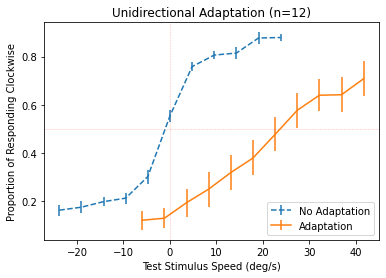

In [ ]:
files = glob.glob('data/Bidirectional/*.csv')
files = [f for f in files if '_practice' not in f]
files.sort()

files_noadapt = []
files_adapt = glob.glob('data/Unidirectional/*.csv')
for subject in subjects:
    tmp = [f for f in files if subject in f]
    files_noadapt.append(tmp[-1])
    assert('_noAdapt' in tmp[0])

speeds_noadapt, props_noadapt = [], []
for f in files_noadapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds_noadapt = count_data.index.tolist()

    cw_counts = count_data.tolist()
    cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
    props_noadapt.append(cw_proportions)

speeds_adapt_1, speeds_adapt_2 = [], []
props_adapt_1, props_adapt_2 = [], []
for f in files_adapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds = count_data.index.tolist()

    cw_counts = count_data.tolist()
    cw_proportions = [r / c for r, c in zip(cw_counts, total_counts)]
    if speeds_adapt_1 == [] or speeds == speeds_adapt_1:
        speeds_adapt_1 = speeds
        props_adapt_1.append(cw_proportions)
    else:
        speeds_adapt_2 = [-s for s in speeds]
        props_adapt_1.append([1-p for p in cw_proportions][::-1])

speeds_noadapt = [s*0.595 for s in speeds_noadapt]
speeds_adapt_1 = [s*0.595 for s in speeds_adapt_1]
speeds_adapt_2 = [s*0.595 for s in speeds_adapt_2]

props_avg_noadapt = np.mean(props_noadapt, axis=0)
props_avg_adapt_1 = np.mean(props_adapt_1, axis=0)

print("No Adapt Stats")
print("==============")
print(props_avg_noadapt)
print(sem(props_noadapt, axis=0))

print("Adapt1 Stats")
print("============")
print(props_avg_adapt_1)
print(sem(props_adapt_1, axis=0))

plt.clf()
plt.errorbar(speeds_noadapt, props_avg_noadapt, yerr=sem(props_noadapt, axis=0), linestyle='dashed', label='No Adaptation')
plt.errorbar(speeds_adapt_1, props_avg_adapt_1, yerr=sem(props_adapt_1, axis=0), label='Adaptation')
plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title('Unidirectional Adaptation (n=12)')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig('plots/average_unidirectional.svg')